# Etapas
1. inserir as bibliotecas
2. carregar os dados
3. Analisar e escolher as features
4. Tratar os dados
5. Testar vários modelos e escolho um
6. Aplicar o modelo escolhido na base de treino
6. Exportar o resultado

# 1.Inserindo as bibliotecas

In [1]:
#importando bibliotecas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from google.colab import drive
from datetime import datetime
from google.colab import files

!pip install tpot

from tpot import TPOTClassifier, TPOTRegressor #ferramente de autoML TPOT 
from deap.gp import Primitive
import time
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import metrics
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 163kB 15.1MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=8822e1cb20711336c3b1b6aec4a48cfd73c3726fff8a82d3fcec75bcb9f26f43
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


Using TensorFlow backend.


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# 2. Carregando os dados

In [18]:
dados_teste = pd.read_csv("test.csv")
dados_treino = pd.read_csv("train.csv")

# 3. Analisando os dados e escolhendo as features

In [19]:
#definindo os dados utilizados no treino para o desafio 1 para uma correlação maior ue 0.3
correlacao1 = dados_treino.corr()[dados_treino.corr()['NU_NOTA_MT']<-0.25]['NU_NOTA_MT']
correlacao2 = dados_treino.corr()[dados_treino.corr()['NU_NOTA_MT']>0.25]['NU_NOTA_MT']
feature_correlacao1 = correlacao1.index.to_list()
feature_correlacao2 = correlacao2.index.to_list()
feature_correlacao = feature_correlacao1 + feature_correlacao2
feature_correlacao.remove('NU_NOTA_MT')
print(feature_correlacao)
#usando como critério 0,3 entraria as notas comp2~5 mas não a 1 o que não faria sentido
#farei o teste usando 0,3  e 0,2 e adotarei o melhor resultado

['Q037', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']


In [20]:
#analisando os dados
notas = dados_treino[['Q037','NU_NOTA_MT','TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']]
notas.describe()
xfeatures = dados_treino[['Q037','TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']]
ylabels = dados_treino[['NU_NOTA_MT']]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text major ticklabel objects>)

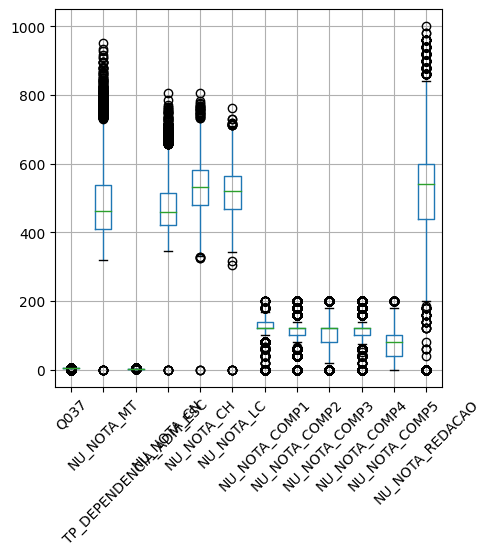

In [21]:
plt.figure(figsize=(5, 5), dpi=100) #indica o tamanho da figura
notas.boxplot(column=['Q037','NU_NOTA_MT','TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'])  #constroi o boxplot
plt.xticks(rotation=45)
#existem 3 escalas diferentes, uma indo de:
#1 a 4 (TP DEPENDENCIA ADM ESC),
#de 400 a 1000(nota CN CH LC redação)
#de 100 a 200(nota das comps) lembrando que a soma dessas notas é a nota de redação e eu devo tomar cuidado
#com essa diferença de escala talvez seja necessário um scaler e talvez desconsiderar a nota da redação

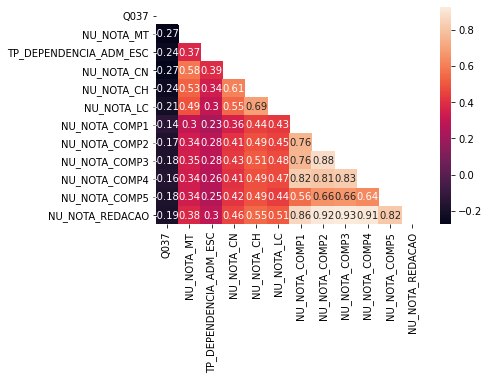

In [22]:
corr = notas.corr()

mask_ut=np.triu(np.ones(corr.shape)).astype(np.bool)
mask_ut[0:len(corr),0:len(corr)]
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        mask=mask_ut)
# de fato fez sentido utilitazar a ntoa da comp1 visto que ela é 0,3 bem em cima do limite previamente estipulado
#logo fez sentido utilizar features com correlação maior que 0,2

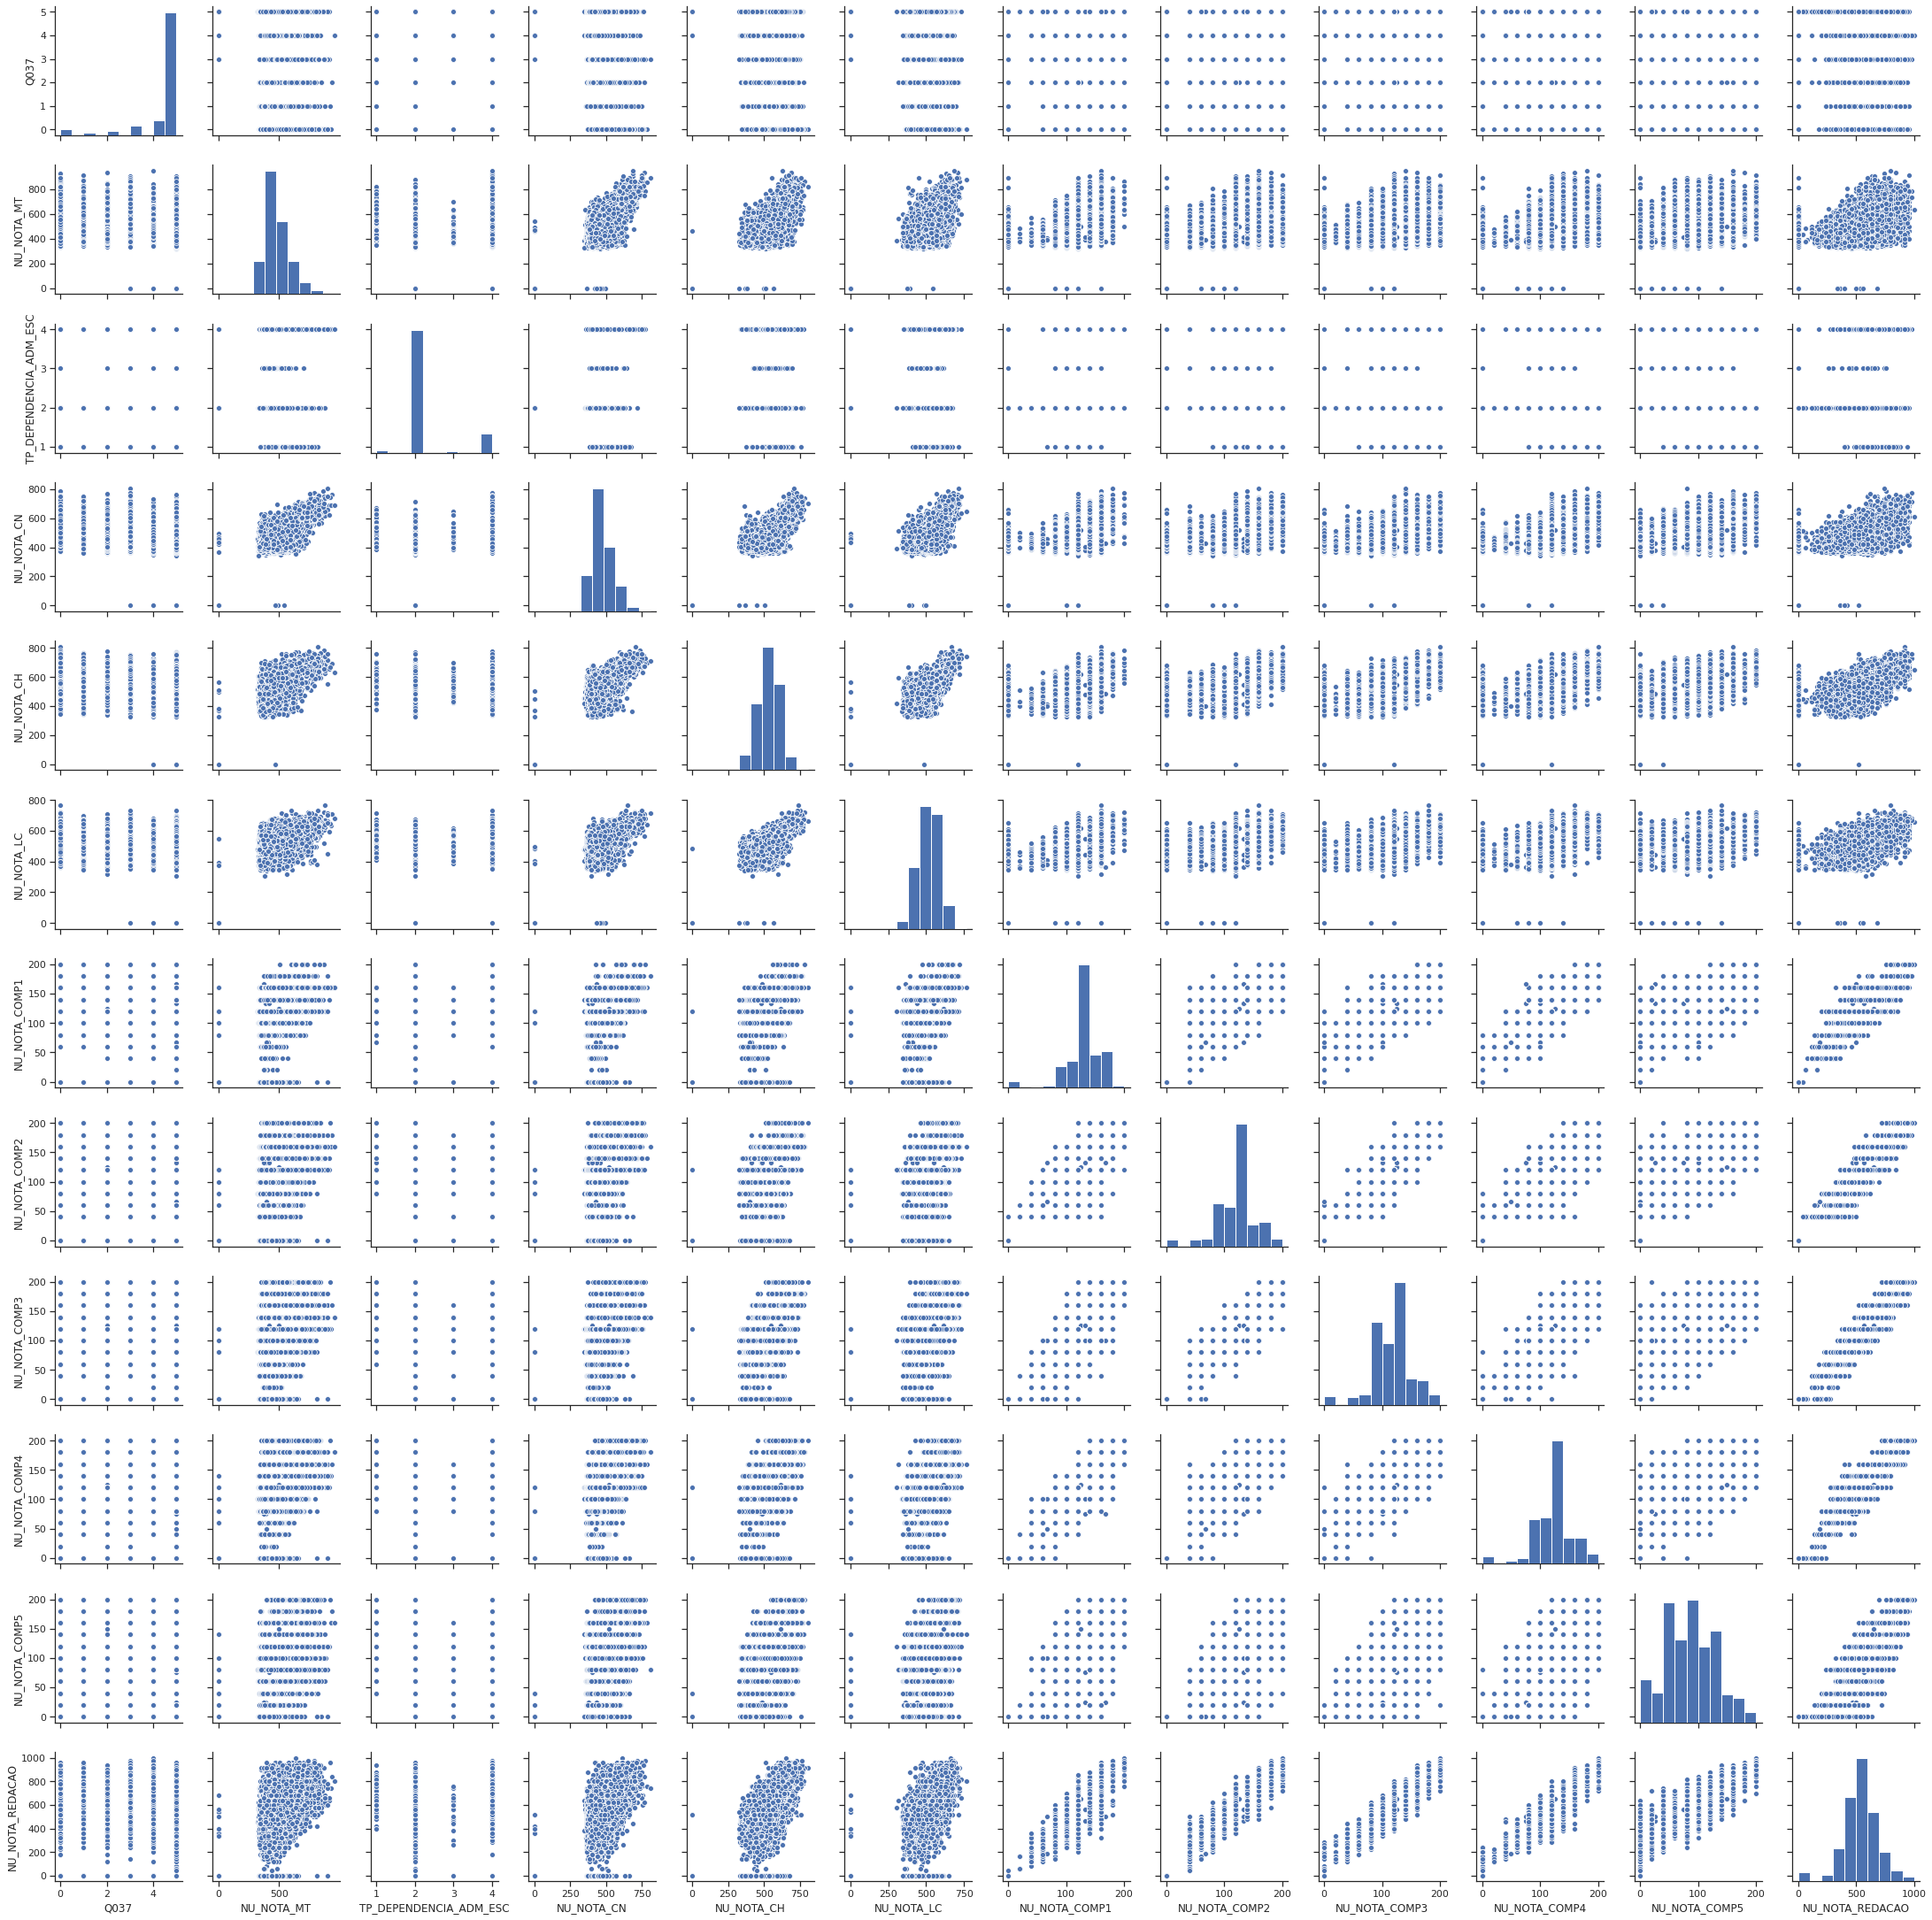

In [23]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(notas, palette="husl")
# o comportamento das notas são muito parecidos já a o comportamento da redação e das comps se diferem um pouco
#o comportamento da TP_DEPENDENCIA_ADM_ESC é diferente dos demais mas demonstra notas maiores para quem apresenta valor de 1
#de fato o scaler poderá fazer sentido

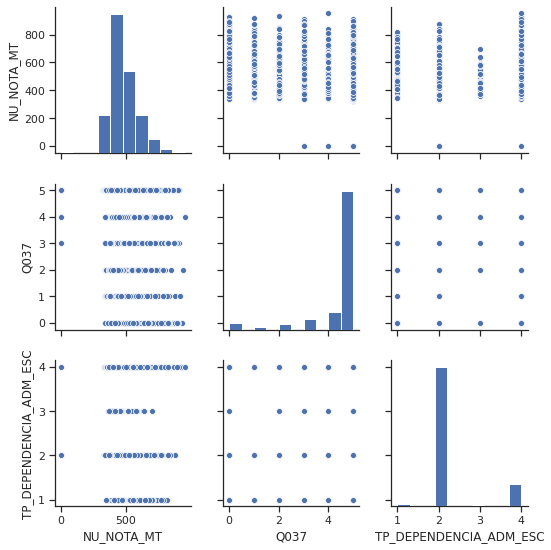

In [24]:
teste = notas[['NU_NOTA_MT','Q037','TP_DEPENDENCIA_ADM_ESC']]
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(teste, palette="husl")
# o comportamento das notas são muito parecidos já a o comportamento da redação e das comps se diferem um pouco
#o comportamento da TP_DEPENDENCIA_ADM_ESC é diferente dos demais mas demonstra notas maiores para quem apresenta valor de 1
#de fato o scaler poderá fazer sentido

# 4. Tratando os dados

In [25]:
#para evitar erros vou substituir os dados nulos por zero
#primeiro eu havia considerado substituir pela média o R2score ficou muito baixo no comparativo
#Q037 não tem NA por isso não tem necessidade disso
notas2 = notas.copy()
notas2["NU_NOTA_CN"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_CH"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_LC"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_MT"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_REDACAO"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_COMP1"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_COMP2"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_COMP3"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_COMP4"].fillna(value = 0, inplace=True)
notas2["NU_NOTA_COMP5"].fillna(value = 0, inplace=True)
notas2["TP_DEPENDENCIA_ADM_ESC"].fillna(value = 0, inplace=True)

#agora para os dados de teste
#q037 não existe no dados teste
teste2 = dados_teste.copy()
teste2["NU_NOTA_CN"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_CH"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_LC"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_REDACAO"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_COMP1"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_COMP2"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_COMP3"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_COMP4"].fillna(value = 0, inplace=True)
teste2["NU_NOTA_COMP5"].fillna(value = 0, inplace=True)
teste2["TP_DEPENDENCIA_ADM_ESC"].fillna(value = 0, inplace=True)

In [26]:
from sklearn.model_selection import cross_val_score

In [72]:
#separação dos dados de teste e treino do modelo
y = notas2[['NU_NOTA_MT']]
x = notas2[['TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']]
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size =0.25, random_state =40)
print(x_treino.shape, x_teste.shape,y_treino.shape,y_teste.shape)
ylabels.shape

(10297, 10) (3433, 10) (10297, 1) (3433, 1)


(13730, 1)

In [73]:
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(x, y)
print(tpot.score(x, y))
tpot.export('tpot_boston_pipeline.py')


Generation 1 - Current best internal CV score: -4087.349406793683
Generation 2 - Current best internal CV score: -4087.349406793683
Generation 3 - Current best internal CV score: -4052.055431303025
Generation 4 - Current best internal CV score: -4044.733841156839

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=2, min_child_weight=19, n_estimators=100, nthread=1, objective=reg:squarederror, subsample=0.8)
-3905.4342187094635


In [45]:
preditos = tpot.predict(x)
modelo_tpot = [['n']]
R2_tpot =r2_score(y,preditos)
R2_tpot

0.9366351546297667

# 5. Aplicando os modelos

In [46]:
#agora usando o minmax scaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
rescaled_x = pd.DataFrame(scaler.fit_transform(x))
REx_treino, REx_teste, REy_treino, REy_teste = train_test_split(rescaled_x, y, test_size =0.25, random_state =40)

In [47]:
y_treino

,NU_NOTA_MT
493,426.9
12539,404.5
9382,461.9
5628,423.9
7070,0.0
...,...
11532,0.0
5426,502.3
7608,440.7
11256,439.0


In [49]:
def Regressao(i_treino,i_teste,j_treino,j_teste):
  regressor = linear_model.LinearRegression()
  regressor.fit(i_treino, j_treino)
  MT_previsao = regressor.predict(i_teste)
  previsao = pd.concat([i_teste,j_teste], axis=1)
  previsao['previsao']=MT_previsao
  return previsao

In [50]:
modelo1 = Regressao(x_treino,x_teste,y_treino,y_teste)
modelo1_rescaled = Regressao(REx_treino,REx_teste,REy_treino, REy_teste)
modelo1_rescaled.head()

#percebi algo interessante, tenta acertar mesmo os número muito próximos de zero mas é de conhecimento que no enem a nota minima
#foi maior que 100 pelo menos então vou substituir os valores onde a previsão foi menor que 100 por zero

,0,1,2,3,4,5,6,7,8,9,10,NU_NOTA_MT,previsao
581,-0.382455,1.159451,1.017031,0.765506,0.508263,1.221649,1.705523,1.463230,1.679698,1.251414,1.529667,555.4,525.264948
1944,0.450790,-0.630839,0.636906,0.989152,1.028630,1.221649,1.355327,1.463230,1.331619,1.251414,1.380268,600.3,558.514948
4945,0.450790,-0.630839,-1.671998,-1.681937,-1.624391,-1.509181,-1.446240,-1.421342,-1.453016,-1.136109,-1.458311,0.0,-6.985052
5516,0.450790,-0.630839,0.622828,0.516542,0.482671,1.221649,0.654935,0.742087,0.983540,1.251414,1.006771,517.9,479.577448
4954,0.450790,1.159451,0.627521,0.330874,0.550916,0.538941,0.654935,0.742087,0.635460,1.251414,0.782672,463.3,491.889948


In [51]:
for index, row in modelo1.iterrows():
  if row['previsao'] <= 100:
    modelo1.loc[index, 'previsao'] = 0

modelo1.head()
for index, row in modelo1_rescaled.iterrows():
  if row['previsao'] <= 100:
    modelo1_rescaled.loc[index, 'previsao'] = 0

modelo1_rescaled.head()

,0,1,2,3,4,5,6,7,8,9,10,NU_NOTA_MT,previsao
581,-0.382455,1.159451,1.017031,0.765506,0.508263,1.221649,1.705523,1.463230,1.679698,1.251414,1.529667,555.4,525.264948
1944,0.450790,-0.630839,0.636906,0.989152,1.028630,1.221649,1.355327,1.463230,1.331619,1.251414,1.380268,600.3,558.514948
4945,0.450790,-0.630839,-1.671998,-1.681937,-1.624391,-1.509181,-1.446240,-1.421342,-1.453016,-1.136109,-1.458311,0.0,0.000000
5516,0.450790,-0.630839,0.622828,0.516542,0.482671,1.221649,0.654935,0.742087,0.983540,1.251414,1.006771,517.9,479.577448
4954,0.450790,1.159451,0.627521,0.330874,0.550916,0.538941,0.654935,0.742087,0.635460,1.251414,0.782672,463.3,491.889948


In [52]:
R1 =r2_score(modelo1['NU_NOTA_MT'],modelo1['previsao'])
R1_rescaled =r2_score(modelo1_rescaled['NU_NOTA_MT'],modelo1_rescaled['previsao'])
print(R1, R1_rescaled)
# o rescale Min e Max não melhorou o resultado
# o standard scale foi melhor contudo contribuiu pouco para o resultado

0.9075537513199844 0.9075688898780272


In [53]:
def modelo_SVR(i_treino,i_teste,j_treino,j_teste):
  regressor_svr = SVR(C=10000)
  regressor_svr.fit(i_treino, j_treino)
  MT_previsao = regressor_svr.predict(i_teste)
  previsao = pd.concat([i_teste,j_teste], axis=1)
  previsao['previsao']=MT_previsao
  return previsao

In [54]:
modelo2 = modelo_SVR(x_treino,x_teste,y_treino,y_teste)

In [55]:
for index, row in modelo2.iterrows():
  if row['previsao'] <= 100:
    modelo2.loc[index, 'previsao'] = 0

modelo2.head()

,Q037,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,NU_NOTA_MT,previsao
581,4,2,573,580,500,160,180,160,180,120,800,555.4,564.376873
1944,5,0,492,633,622,160,160,160,160,120,760,600.3,523.052597
4945,5,0,0,0,0,0,0,0,0,0,0,0.0,0.000000
5516,5,0,489,521,494,160,120,120,140,120,660,517.9,463.336490
4954,5,2,490,477,510,120,120,120,120,120,600,463.3,435.351821


In [56]:
R2 =r2_score(modelo2['NU_NOTA_MT'],modelo2['previsao'])
print(R2)
#por hora o SVR tem apresentado o melhor resultado

0.9202463510860782


In [57]:
def modelo_MLP(i_treino,i_teste,j_treino,j_teste):
  regressor_MLP = MLPRegressor(max_iter=500)
  regressor_MLP.fit(i_treino, j_treino)
  MT_previsao = regressor_MLP.predict(i_teste)
  previsao = pd.concat([i_teste,j_teste], axis=1)
  previsao['previsao']=MT_previsao
  return previsao

In [58]:
modelo3 = modelo_MLP(x_treino,x_teste,y_treino,y_teste)
for index, row in modelo3.iterrows():
  if row['previsao'] <= 100:
    modelo3.loc[index, 'previsao'] = 0
modelo3.head()

,Q037,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,NU_NOTA_MT,previsao
581,4,2,573,580,500,160,180,160,180,120,800,555.4,552.816331
1944,5,0,492,633,622,160,160,160,160,120,760,600.3,512.823500
4945,5,0,0,0,0,0,0,0,0,0,0,0.0,0.000000
5516,5,0,489,521,494,160,120,120,140,120,660,517.9,470.127837
4954,5,2,490,477,510,120,120,120,120,120,600,463.3,457.192386


In [59]:
R3 =r2_score(modelo3['NU_NOTA_MT'],modelo3['previsao'])
print(R3)
#SVR foi melhor q MLP com 500 interações e aumentar o número máximo de interações não melhorou o resulado

0.9134539330992248


In [60]:
def modelo_GBR(i_treino,i_teste,j_treino,j_teste):
  regressor = GradientBoostingRegressor()
  regressor.fit(i_treino, j_treino)
  MT_previsao = regressor.predict(i_teste)
  previsao = pd.concat([i_teste,j_teste], axis=1)
  previsao['previsao']=MT_previsao
  return previsao


In [61]:
modelo4 = modelo_GBR(x_treino,x_teste,y_treino,y_teste)
for index, row in modelo4.iterrows():
  if row['previsao'] <= 100:
    modelo4.loc[index, 'previsao'] = 0
modelo4.head()

,Q037,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,NU_NOTA_MT,previsao
581,4,2,573,580,500,160,180,160,180,120,800,555.4,547.694222
1944,5,0,492,633,622,160,160,160,160,120,760,600.3,518.530381
4945,5,0,0,0,0,0,0,0,0,0,0,0.0,0.000000
5516,5,0,489,521,494,160,120,120,140,120,660,517.9,454.068290
4954,5,2,490,477,510,120,120,120,120,120,600,463.3,447.270691


In [62]:
R4 =r2_score(modelo4['NU_NOTA_MT'],modelo4['previsao'])
print(R1, R2, R3, R4)
#por hora foi o melhor modelo

0.9075537513199844 0.9202463510860782 0.9134539330992248 0.9216383147031268


In [63]:
def modelo_Tree(i_treino,i_teste,j_treino,j_teste):
  regressor = DecisionTreeRegressor()
  regressor.fit(i_treino, j_treino)
  MT_previsao = regressor.predict(i_teste)
  previsao = pd.concat([i_teste,j_teste], axis=1)
  previsao['previsao']=MT_previsao
  return previsao

In [64]:
modelo5 = modelo_Tree(x_treino,x_teste,y_treino,y_teste)
for index, row in modelo5.iterrows():
  if row['previsao'] <= 100:
    modelo5.loc[index, 'previsao'] = 0
modelo5.head()

,Q037,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,NU_NOTA_MT,previsao
581,4,2,573,580,500,160,180,160,180,120,800,555.4,620.6
1944,5,0,492,633,622,160,160,160,160,120,760,600.3,480.8
4945,5,0,0,0,0,0,0,0,0,0,0,0.0,0.0
5516,5,0,489,521,494,160,120,120,140,120,660,517.9,381.6
4954,5,2,490,477,510,120,120,120,120,120,600,463.3,372.8


In [65]:
R5 =r2_score(modelo5['NU_NOTA_MT'],modelo5['previsao'])
print(R1, R2, R3, R4, R5)
#por hora foi o pior
#vou optar pelo GBR

0.9075537513199844 0.9202463510860782 0.9134539330992248 0.9216383147031268 0.8367350880677444


# 6. Aplicando na base inteira
Uma vez escolhido o GBR, eu vou treinar o meu modelo da resposta com todos os dados da minha base de treino e colocar para prever a nota de Matemática usando o GBR para logo em seguida transformar notas abaixo de 100 de matemática para zero.

In [66]:
y = notas2[['NU_NOTA_MT']].astype(int)
x = notas2[['TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']].astype(int)
teste = teste2[['TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']].astype(int)

regressor = GradientBoostingRegressor()
regressor.fit(x, y['NU_NOTA_MT'])
MT_previsao = regressor.predict(teste)
resultado = pd.DataFrame({'NU_INSCRICAO': dados_teste['NU_INSCRICAO']})
resultado['NU_NOTA_MT'] = MT_previsao
for index, row in resultado.iterrows():
  if row['NU_NOTA_MT'] <= 100:
    resultado.loc[index, 'NU_NOTA_MT'] = 0
resultado.head()


,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,435.282198
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,452.262393
2,b38a03232f43b11c9d0788abaf060f7366053b6d,579.943805
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,535.536991


In [74]:
teste = teste2[['TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']]
MT_previsao = tpot.predict(teste)
resultado = pd.DataFrame({'NU_INSCRICAO': dados_teste['NU_INSCRICAO']})
resultado['NU_NOTA_MT'] = MT_previsao
for index, row in resultado.iterrows():
  if row['NU_NOTA_MT'] <= 100:
    resultado.loc[index, 'NU_NOTA_MT'] = 0
resultado.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,434.169342
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,454.994110
2,b38a03232f43b11c9d0788abaf060f7366053b6d,586.474243
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,537.838196


# 7. Download do arquivo

In [75]:
#download do arquivo
resultado.to_csv('answer.csv', index = False)
files.download('answer.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>